#Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! git clone https://github.com/Arman-Rayan-Sharif/arman-text-emotion.git

fatal: destination path 'arman-text-emotion' already exists and is not an empty directory.


In [ ]:
DATA_PATH = '/content/arman-text-emotion/dataset'

In [ ]:
pip install hazm


In [ ]:
from hazm import Normalizer
normalizer = Normalizer(persian_numbers=False,persian_style=False)
def preproc(text):
  ans=normalizer.normalize(text)
  return ans

In [ ]:
!pip install torch==2.10.0+cu121 -f https://download.pytorch.org/whl/cu121/torch_stable.html
!pip install sentencepiece
!pip install transformers


Looking in links: https://download.pytorch.org/whl/cu121/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==2.10.0+cu121 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.0+cu121, 2.1.1, 2.1.1+cu121, 2.1.2, 2.1.2+cu121, 2.2.0, 2.2.0+cu121)
ERROR: No matching distribution found for torch==2.10.0+cu121


In [ ]:
import pandas as pd
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, RobertaModel, RobertaTokenizer,XLMRobertaTokenizer  ,AutoConfig,AutoTokenizer,AutoModel
from transformers import XLMRobertaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
label_dict = {
  'OTHER': 0,
  'HAPPY': 1,
  'SURPRISE': 2,
  'FEAR': 3,
  'HATE': 4,
  'ANGRY': 5,
  'SAD': 6,
}

In [ ]:
train_df = pd.read_table(f'{DATA_PATH}/train.tsv', header=None)
train_df[1] = train_df[1].map(label_dict)
train_texts, train_labels = train_df[0], train_df[1]
test_df = pd.read_table(f'{DATA_PATH}/test.tsv', header=None)
test_df[1] = test_df[1].map(label_dict)
test_texts, test_labels = test_df[0], test_df[1]
train_labels.fillna(0, inplace=True)
test_labels.fillna(0, inplace=True)
train_texts=train_texts.map(normalizer.normalize)
test_texts=test_texts.map(normalizer.normalize)
data = {
    'train': {'texts': train_texts, 'labels': train_labels},
    'test': {'texts': test_texts, 'labels': test_labels},
}

# Train Model

In [ ]:
class TextClassificationDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
    return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}


In [ ]:
class RobertaClassifier(nn.Module):
  def __init__(self, bert_model_name, num_classes):
    super(RobertaClassifier, self).__init__()
    self.bert = RobertaModel.from_pretrained(bert_model_name)
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    logits = self.fc(x)
    return logits

In [ ]:
class XLMRobertaClassifier(nn.Module):
  def __init__(self, model_name, num_classes):
    super(XLMRobertaClassifier, self).__init__()
    self.bert = XLMRobertaModel.from_pretrained(model_name)
    self.dropout = nn.Dropout(0.1)
    self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = outputs.pooler_output
    x = self.dropout(pooled_output)
    logits = self.fc(x)
    return logits

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
  model.train()
  predictions = []
  actual_labels = []
  for batch in tqdm(data_loader, position=0):
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    labels = labels.long()
    probabilities = F.softmax(outputs, dim=1)
    loss = nn.CrossEntropyLoss()(probabilities, labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    _, preds = torch.max(outputs, dim=1)
    predictions.extend(preds.cpu().tolist())
    actual_labels.extend(labels.cpu().tolist())
  return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [ ]:
def evaluate(model, data_loader, device):
  model.eval()
  predictions = []
  actual_labels = []
  with torch.no_grad():
    for batch in tqdm(data_loader, position=0):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      predictions.extend(preds.cpu().tolist())
      actual_labels.extend(labels.cpu().tolist())
  return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [ ]:
num_classes = 7
max_length = 128
batch_size = 32
num_epochs = 6
learning_rate = 2e-5

In [ ]:
def main(data, language_model, layer=None, tokenizer_class=AutoTokenizer, classifier_class=XLMRobertaClassifier):
    tokenizer = tokenizer_class.from_pretrained(language_model)
    train_dataset = TextClassificationDataset(data['train']['texts'], data['train']['labels'], tokenizer, max_length)
    val_dataset = TextClassificationDataset(data['test']['texts'], data['test']['labels'], tokenizer, max_length)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = classifier_class(language_model, num_classes).to(device)

    if layer:
        for name, param in model.named_parameters():
            if layer in name:
                break
            param.requires_grad = False

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_dataloader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    reports = {'train': list(), 'val': list()}
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_accuracy, train_report = train(model, train_dataloader, optimizer, scheduler, device)
        val_accuracy, val_report = evaluate(model, val_dataloader, device)
        print(f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        print('-' * 20)
        reports['val'].append([val_accuracy, val_report])
        reports['train'].append([train_accuracy, train_report])
    print(val_report)
    return model, reports

In [ ]:
def plot_report(reports):
  val = [i[0] for i in reports['val']]
  train = [i[0] for i in reports['train']]
  x = range(len(val))
  plt.plot(x, train, label='train')
  plt.plot(x, val, label='val')
  plt.legend()

In [ ]:
xlm_roberta_model = 'xlm-roberta-large'
xlm_roberta_model_instance, xlm_roberta_reports = main(data, xlm_roberta_model, layer='11', tokenizer_class=XLMRobertaTokenizer, classifier_class=XLMRobertaClassifier)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch 1/6


100%|██████████| 192/192 [04:40<00:00,  1.46s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|█████████

Train Accuracy: 0.2844, Validation Accuracy: 0.2163
--------------------
Epoch 2/6


100%|██████████| 192/192 [04:44<00:00,  1.48s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|█████████

Train Accuracy: 0.4137, Validation Accuracy: 0.4666
--------------------
Epoch 3/6


100%|██████████| 192/192 [04:44<00:00,  1.48s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|█████████

Train Accuracy: 0.5464, Validation Accuracy: 0.5074
--------------------
Epoch 4/6


100%|██████████| 36/36 [00:24<00:00,  1.45it/s]


Train Accuracy: 0.6462, Validation Accuracy: 0.6342
--------------------
Epoch 5/6


100%|██████████| 36/36 [00:24<00:00,  1.44it/s]


Train Accuracy: 0.7104, Validation Accuracy: 0.6890
--------------------
Epoch 6/6


100%|██████████| 36/36 [00:24<00:00,  1.45it/s]

Train Accuracy: 0.7332, Validation Accuracy: 0.7202
--------------------
              precision    recall  f1-score   support

           0       0.58      0.81      0.68       193
           1       0.91      0.66      0.77       275
           2       0.82      0.64      0.72       145
           3       0.76      0.77      0.77        57
           4       0.81      0.38      0.52        65
           5       0.68      0.64      0.66       154
           6       0.69      0.89      0.77       262

    accuracy                           0.72      1151
   macro avg       0.75      0.68      0.70      1151
weighted avg       0.75      0.72      0.72      1151



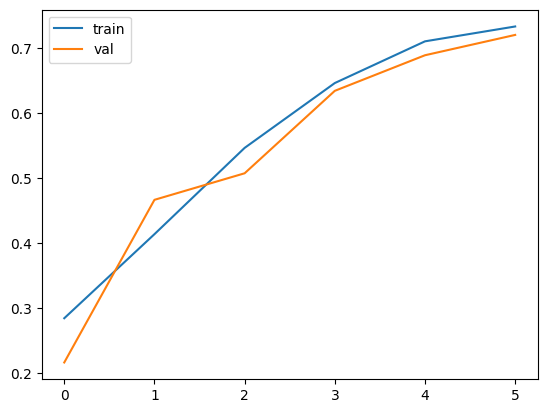

In [ ]:
plot_report(xlm_roberta_reports)

In [ ]:
import joblib

joblib.dump(xlm_roberta_model_instance, '/content/drive/MyDrive/model_proj.joblib')

loaded_model = joblib.load('/content/drive/MyDrive/model_proj.joblib')